<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C1/W4/ungraded_labs/C1_W4_Lab_3_compacted_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Effect of Compacted Images in Training

In this notebook, you will see how reducing the target size of the generator images will affect the architecture and performance of your model. This is a useful technique in case you need to speed up your training or save compute resources. Let's begin!

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

You can check that the directories are not empty and that the train set has more images than the validation set:

In [3]:
train_horse_names = os.listdir(train_horse_dir)
print(f'TRAIN SET HORSES: {train_horse_names[:10]}')

train_human_names = os.listdir(train_human_dir)
print(f'TRAIN SET HUMANS: {train_human_names[:10]}')

validation_horse_hames = os.listdir(validation_horse_dir)
print(f'VAL SET HORSES: {validation_horse_hames[:10]}')

validation_human_names = os.listdir(validation_human_dir)
print(f'VAL SET HUMANS: {validation_human_names[:10]}')

TRAIN SET HORSES: ['horse43-5.png', 'horse06-5.png', 'horse20-6.png', 'horse04-7.png', 'horse41-7.png', 'horse22-4.png', 'horse19-2.png', 'horse24-2.png', 'horse37-8.png', 'horse02-1.png']
TRAIN SET HUMANS: ['human17-22.png', 'human10-17.png', 'human10-03.png', 'human07-27.png', 'human09-22.png', 'human05-22.png', 'human02-03.png', 'human02-17.png', 'human15-27.png', 'human12-12.png']
VAL SET HORSES: ['horse1-204.png', 'horse2-112.png', 'horse3-498.png', 'horse5-032.png', 'horse5-018.png', 'horse1-170.png', 'horse5-192.png', 'horse1-411.png', 'horse4-232.png', 'horse3-070.png']
VAL SET HUMANS: ['valhuman04-20.png', 'valhuman03-01.png', 'valhuman04-08.png', 'valhuman03-15.png', 'valhuman01-04.png', 'valhuman01-10.png', 'valhuman01-11.png', 'valhuman01-05.png', 'valhuman03-14.png', 'valhuman03-00.png']


In [4]:
print(f'total training horse images: {len(os.listdir(train_horse_dir))}')
print(f'total training human images: {len(os.listdir(train_human_dir))}')
print(f'total validation horse images: {len(os.listdir(validation_horse_dir))}')
print(f'total validation human images: {len(os.listdir(validation_human_dir))}')

total training horse images: 500
total training human images: 527
total validation horse images: 128
total validation human images: 128


## Build the Model

The model will follow the same architecture as before but they key difference is in the `input_shape` parameter of the first `Conv2D` layer. Since you will be compacting the images later in the generator, you need to specify the expected image size here. So instead of 300x300 as in the previous two labs, you specify a smaller 150x150 array.

In [5]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
#     # The fourth convolution (You can uncomment the 4th and 5th conv layers later to see the effect)
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # The fifth convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

2023-04-07 22:55:30.352084: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


You can see the difference from previous models when you print the `model.summary()`. As expected, there will be less inputs to the `Dense` layer at the end of the model compared to the previous labs. This is because you used the same number of max pooling layers in your model. And since you have a smaller image to begin with (150 x 150), then the output after all the pooling layers will also be smaller.

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

You will use the same settings for training:

In [7]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

### Data Preprocessing

Now you will instantiate the data generators. As mentioned before, you will be compacting the image by specifying the `target_size` parameter. See the simple change below:

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        './horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=128,
        # Since you used binary_crossentropy loss, you need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        './validation-horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=32,
        # Since you used binary_crossentropy loss, you need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


### Training

Now you're ready to train and see the results. Note your observations about how fast the model trains and the accuracies you're getting in the train and validation sets.

In [9]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/15


2023-04-07 22:55:45.209381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - ETA: 0s - loss: 0.7917 - accuracy: 0.4928

2023-04-07 22:55:55.468281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 12s 1s/step - loss: 0.7917 - accuracy: 0.4928 - val_loss: 0.8381 - val_accuracy: 0.5000
Epoch 2/15
8/8 [==============================] - 11s 1s/step - loss: 0.6529 - accuracy: 0.6630 - val_loss: 0.6824 - val_accuracy: 0.5000
Epoch 3/15
8/8 [==============================] - 10s 1s/step - loss: 0.7403 - accuracy: 0.5284 - val_loss: 1.0395 - val_accuracy: 0.5000
Epoch 4/15
8/8 [==============================] - 11s 1s/step - loss: 0.5154 - accuracy: 0.7631 - val_loss: 0.3042 - val_accuracy: 0.8789
Epoch 5/15
8/8 [==============================] - 11s 2s/step - loss: 0.3900 - accuracy: 0.8331 - val_loss: 0.3240 - val_accuracy: 0.8867
Epoch 6/15
8/8 [==============================] - 12s 2s/step - loss: 0.2057 - accuracy: 0.9366 - val_loss: 0.9558 - val_accuracy: 0.7969
Epoch 7/15
8/8 [==============================] - 13s 2s/step - loss: 0.2712 - accuracy: 0.9033 - val_loss: 0.7148 - val_accuracy: 0.8242
Epoch 8/15
8/8 [=============================

### Model Prediction

As usual, it is also good practice to try running your model over some handpicked images. See if you got better, worse, or the same performance as the previous lab.

_**Note:** Old versions of the Safari browser might have compatibility issues with the code block below. If you get an error after you select the images(s) to upload, you can consider updating your browser to the latest version. If not possible, please comment out or skip the code block below, uncomment the next code block and run it._

In [11]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

dir = './horse-or-human-test'

for file in os.listdir(dir):
  #print(f'loading {file}')
  if file != '.DS_Store':
    # predicting images
    img = load_img(os.path.join(dir, file), target_size=(150, 150))
    x = img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
      
    if classes[0]>0.5:
      print(file + " is a human")
    else:
      print(file + " is a horse")
  

1/1 [==============================] - 0s 95ms/step
[0.34925753]
persona5.jpg is a horse
1/1 [==============================] - 0s 32ms/step
[1.]
persona2.jpg is a human
1/1 [==============================] - 0s 28ms/step
[0.9999688]
persona.jpg is a human
1/1 [==============================] - 0s 59ms/step
[0.01727629]
caballo.jpg is a horse
1/1 [==============================] - 0s 28ms/step
[0.00043746]
caballo2.jpg is a horse
1/1 [==============================] - 0s 28ms/step
[0.0282225]
caballo3.jpg is a horse
1/1 [==============================] - 0s 45ms/step
[0.9052117]
caballo1.jpg is a human
1/1 [==============================] - 0s 36ms/step
[0.99957013]
caballo4.jpg is a human
1/1 [==============================] - 0s 31ms/step
[0.598029]
persona3.webp is a human
1/1 [==============================] - 0s 30ms/step
[0.15963794]
caballo5.jpg is a horse
1/1 [==============================] - 0s 27ms/step
[0.90095437]
caballo7.jpg is a human
1/1 [==============================

### Visualizing Intermediate Representations

You can also look again at the intermediate representations. You will notice that the output at the last convolution layer is even more abstract because it contains fewer pixels than before.

1/1 [==============================] - 0s 82ms/step


/var/folders/jk/j9m2zrh50x93rkvk8mwm6kc40000gn/T/ipykernel_45952/3806200630.py:47: RuntimeWarning: invalid value encountered in divide
  x /= x.std()


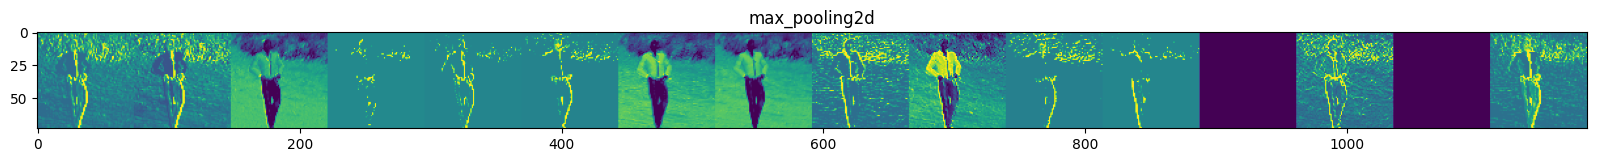

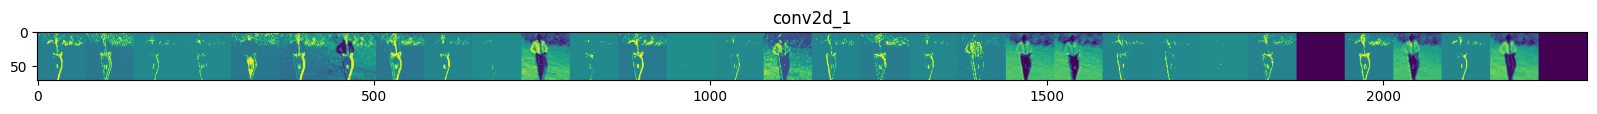

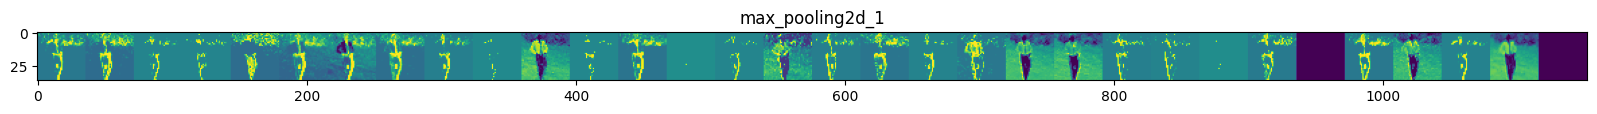

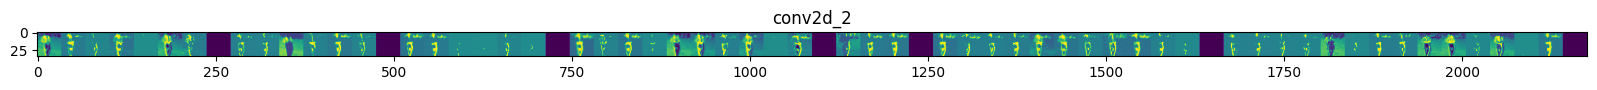

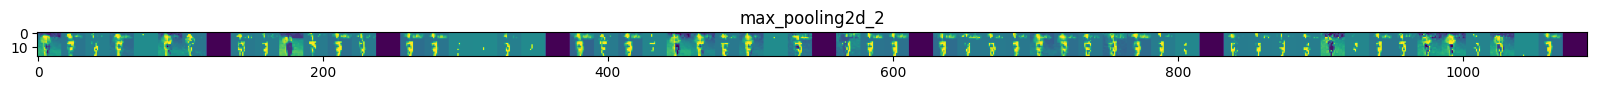

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.utils import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map

    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
    
      # Tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Wrap Up

In this lab, you saw how compacting images affected your previous model. This is one technique to keep in mind especially when you are still in the exploratory phase of your own projects. You can see if a smaller model behaves just as well as a large model so you can have faster training. You also saw how easy it is to customize your images for this adjustment in size by simply changing a parameter in the `ImageDataGenerator` class.